<a href="https://colab.research.google.com/github/cfont03/Anomaly-breast-cancer-detection/blob/main/train/2.Faster_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Data Upload

In [ ]:
# Mount google drive
import zipfile
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Access and unzip images
!unzip "/content/gdrive/MyDrive/99_Output/all-mias.zip" -d "/"
print("DONE!")

Archive:  /content/gdrive/MyDrive/99_Output/all-mias.zip
replace /content/archive/all-mias/mdb155_hflip.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
DONE!


In [1]:
# Importation of libraries
from tensorflow import keras 
print("Keras version   : ", keras.__version__)

%tensorflow_version 2.x
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Multiply, Flatten,
     Dense, Dropout, Conv2D, BatchNormalization, MaxPooling2D)
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential, Model

%pylab inline
import cv2
import glob
import os
import matplotlib.pylab as plt

#from PIL import Image
import PIL.Image
from fastai.vision import *
from fastai.metrics import error_rate
from IPython.display import Image
from keras.preprocessing import image as kp_image
#from tensorflow_addons.utils.ensure_tf_install import _check_tf_version
#import tensorflow_addons as tfa

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix

import seaborn as sns
from matplotlib import patches
import time

Keras version   :  2.8.0
Populating the interactive namespace from numpy and matplotlib


In [ ]:
# read csv file
df = pd.read_csv("/content/gdrive/MyDrive/99_Output/images_preprocess.csv", sep = ";")
df.head()

,Unnamed: 0,name,features,size,cat,x_coord,y_coord,radius,image path,xmin,xmax,ymin,ymax
0,0,mdb001,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,535.0,599.0,197,/content/archive/all-mias/mdb001.pgm,338.0,732.0,402.0,796.0
1,1,mdb002,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,522.0,744.0,69,/content/archive/all-mias/mdb002.pgm,453.0,591.0,675.0,813.0
2,2,mdb005,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,477.0,891.0,30,/content/archive/all-mias/mdb005.pgm,447.0,507.0,861.0,921.0
3,3,mdb005,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,500.0,856.0,26,/content/archive/all-mias/mdb005.pgm,474.0,526.0,830.0,882.0
4,4,mdb010,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,525.0,599.0,33,/content/archive/all-mias/mdb010.pgm,492.0,558.0,566.0,632.0


In [ ]:
# show boundary box to image
def boundary_box (df):
  
  '''

  This function plots an image with its boundary boxes

  Params:
  1: name image
  8: path image
  9: min coord x
  10: max coord x
  11: min coord y
  12: max coord y

  '''

  i = df.iloc[0]
  image = input("introduce image name: ") 
  im = cv2.imread('/content/archive/all-mias/{:}'.format(image))

  # generate x, y, width and height
  xmin, xmax, ymin, ymax = (i[9], i[10], i[11], i[12])
  width = xmax - xmin
  height = ymax - ymin

  # Create figure and axes
  fig, ax = plt.subplots()

  # Display the image
  ax.imshow(im)

  # Create a Rectangle patch
  rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')

  # Add the patch to the Axes
  ax.add_patch(rect)

  plt.show()

introduce image name: mdb001.pgm


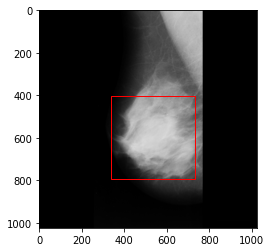

In [ ]:
# apply to our df
boundary_box(df)

#1. Data split and normalization ====> NEEDS TO BE FINALISED



In [ ]:
def train_test_split(df, test, val = 0.25):

  '''

  This function splits data into train, test and validation subsets.


  Params:

  dataframe:
    1: key
    2: features
    7: image path
    8, 9, 10, 11: coordinates of boundary boxes
  
  test: % of test data of all dataframe
  val: % of validation data of train data


  '''


  def randomize_files(df): # randomize df
    df.sample(frac=1).reset_index(drop=True)
    return  df

  def train_test(df):
    x = df.iloc[:,[1,2,7]]
    y = df.iloc[:,[1,7,8,9,10, 11]]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test, random = 1) # split between train and test
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, val, random = 1) # further split val data
    return x_train, x_test, x_val, y_train, y_test, y_val
    #return x_train, x_test, y_train, y_test
  

In [ ]:
def train_test(df, test = 0.2, val = 0.25):
    x = df.iloc[:,[1,2,7]]
    y = df.iloc[:,[1,7,8,9,10, 11]]
    x_train, x_test, y_train, y_test = train_test_split(x, y, 0.2) # split between train and test
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, val) # further split val data
    return x_train, x_test, x_val, y_train, y_test, y_val
    #return x_train, x_test, y_train, y_test

In [ ]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
x_train = train.iloc[:,[1,2,7]]
x_test = test.iloc[:,[1,2,7]]
y_train = train.iloc[:,[1,7,8,9,10, 11]]
y_test = test.iloc[:,[1,7,8,9,10, 11]]
print(x_train)

              name                                           features  \
0           mdb001                              [0 0 0 0 ... 0 0 0 0]   
2           mdb005                              [0 0 0 0 ... 0 0 0 0]   
5           mdb012                              [0 0 0 0 ... 0 0 0 0]   
7           mdb015                              [0 0 0 0 ... 0 0 0 0]   
8           mdb017                              [0 0 0 0 ... 0 0 0 0]   
..             ...                                                ...   
588   mdb314_noise  [[0 0 0]\n [0 0 0]\n [0 0 0]\n [0 0 0]\n ...\n...   
590    mdb314_mask                              [0 0 0 0 ... 0 0 0 0]   
591   mdb315_hflip  [[0 0 0]\n [0 0 0]\n [0 0 0]\n [0 0 0]\n ...\n...   
593  mdb315_rotate  [[0 0 0]\n [0 0 0]\n [0 0 0]\n [0 0 0]\n ...\n...   
594    mdb315_mask                              [0 0 0 0 ... 0 0 0 0]   

                                       image path  
0            /content/archive/all-mias/mdb001.pgm  
2            /conte

In [ ]:
# data needs to be scaled, due to gradient descent technique
  # normalization ==> data distribution is unknown. Therefore, no Gaussian disstribution is assumed               
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder(categorical_features = [0,2])
X = onehotencoder.fit_transform(x_train)
#x_train.to_numpy()
scaled = scaler.fit_transform(x_train)
print(x_train)

TypeError: ignored

#2. Faster R-CNN

##2.1. Stage One Object Detector

###2.1.1. Preprocess

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from urllib import request
from tensorflow.keras import initializers
np.set_printoptions(suppress=True)
from pathlib import Path

In [ ]:
# keep interesting fields
df_ = df.iloc[:, [8, 9, 10, 11, 12]]
df_['height'] = 1024
df_['weight'] = 1024
df_['cat'] = df['cat']
df_.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,image path,xmin,xmax,ymin,ymax,height,weight,cat
590,/content/archive/all-mias/mdb314_mask.pgm,479.000000,557.000000,794.00000,872.000000,1024,1024,MISC
591,/content/archive/all-mias/mdb315_hflip.jpeg,292.000000,686.000000,402.00000,796.000000,1024,1024,CIRC
592,/content/archive/all-mias/mdb315_noise.jpeg,423.000000,609.000000,484.00000,670.000000,1024,1024,CIRC
593,/content/archive/all-mias/mdb315_rotate.jpeg,712.818326,804.742207,797.67114,804.742207,1024,1024,CIRC
594,/content/archive/all-mias/mdb315_mask.pgm,423.000000,609.000000,484.00000,670.000000,1024,1024,CIRC


In [ ]:
# resizing input images to fit into pretrained model, to extract features
def resize (df, h = 800, w = 800):
  
  '''

  Function returns resized images to specified size. Format: df
  Default is 800 x 800.

  Params:
  0: image path
  1: xmin
  2: xmax
  3: ymin
  4: ymax
  5: height original image
  6: weight original image
  7: label

  '''

  paths = []
  xmins = []
  xmaxs = []
  ymins = []
  ymaxs = []
  labels = []

  for i in df.iloc:
    img = cv2.imread(str(i[0]))
    img = cv2.resize(img, dsize = (h,w), interpolation = cv2.INTER_CUBIC)
    path, filename_ext = os.path.split(i[0])
    filename = os.path.basename(i[0]).split('.')[0]
    new_path = Path(str(path)+'/{:}_resize{:}'.format(filename, '.jpeg')) # generate new path
    status = cv2.imwrite(str(new_path), img)
    print("Image written to file-system " , new_path,  " :", status) # check if saved
    paths.append(new_path)

    x_factor = w / i[5]
    y_factor = h / i[6]

    # adapt bounding box accordingly
    xmin = i[1] * x_factor
    xmins.append(xmin)
    xmax = i[2] * x_factor
    xmaxs.append(xmax)
    ymin = i[3] * y_factor
    ymins.append(ymin)
    ymax = i[4] * y_factor
    ymaxs.append(ymax)

    labels.append(i[7])

  arr = np.array([paths, xmins, xmaxs, ymins, ymaxs, labels], dtype = object).T.tolist()
  df_ = pd.DataFrame(data = arr, columns = ['path', 'xmin', 'xmax', 'ymin', 'ymax', 'labels'])
  
  return df_

In [ ]:
# apply to df
df_re = resize(df_, 800, 800)

Image written to file-system  /content/archive/all-mias/mdb001_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb002_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb005_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb005_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb010_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb012_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb013_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb015_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb017_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb019_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb021_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb023_resize.jpeg  : True
Imag

In [ ]:
df_re.head() # check results

,path,xmin,xmax,ymin,ymax,labels
0,/content/archive/all-mias/mdb001_resize.jpeg,264.06250,571.87500,314.06250,621.87500,CIRC
1,/content/archive/all-mias/mdb002_resize.jpeg,353.90625,461.71875,527.34375,635.15625,CIRC
2,/content/archive/all-mias/mdb005_resize.jpeg,349.21875,396.09375,672.65625,719.53125,CIRC
3,/content/archive/all-mias/mdb005_resize.jpeg,370.31250,410.93750,648.43750,689.06250,CIRC
4,/content/archive/all-mias/mdb010_resize.jpeg,384.37500,435.93750,442.18750,493.75000,CIRC


In [ ]:
# show boundary box to resized image

def boundary_box_resize (df):
  
  '''

  This function plots an image with its boundary boxes

  Params:
  0: path image
  1: min coord x
  2: max coord x
  3: min coord y
  4: max coord y
  5: label

  '''

  i = df.iloc[0]
  image = input("introduce image name: ")
  path, filename = os.path.split(i[0])
  im = cv2.imread(str(path) + '/{:}'.format(image))

  # generate x, y, width and height
  xmin, xmax, ymin, ymax = (i[1], i[2], i[3], i[4])
  width = xmax - xmin
  height = ymax - ymin

  # Create figure and axes
  fig, ax = plt.subplots()

  # Display the image
  ax.imshow(im)

  # Create a Rectangle patch
  rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')

  # Add the patch to the Axes
  ax.add_patch(rect)

  plt.show()

introduce image name: mdb010_resize.jpeg


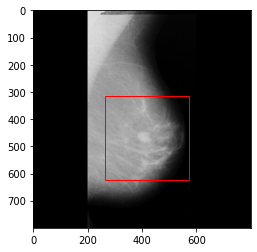

In [ ]:
boundary_box_resize(df_re)

###2.1.2. Convolutional Neural Network

In [ ]:
from numpy.core.fromnumeric import shape

# VGG Network
def vgg16_cnn(df, h = 800, w = 800):

  '''

  Returns a VGG16 model and a list of anchors needed per image passed

  Params: df with
  0: image path

  '''

  # show execution time
  start_time = time.time()


  vgg = tf.keras.applications.VGG16(
    include_top=False, weights='imagenet')

  input = vgg.input
  output = vgg.layers[-1].output

  vgg16_model = Model(inputs = input, outputs = output)
  
  
  # feature map
  anchors = []
  w_fms = []
  h_fms = []

  for i in df.iloc:
    img = cv2.imread(str(i[0]))
    shape_fm = vgg16_model.predict(np.expand_dims(img, 0))
    _, w_fm, h_fm, _ = shape_fm.shape
    n_anchor = w_fm * h_fm    # calculate number of anchors per image
    anchors.append(n_anchor)
    w_fms.append(w_fm)
    h_fms.append(h_fm)


  # add feature map in the df
  df['n_anchor'] = anchors
  df['w_fm'] = w_fms
  df['h_fm'] = h_fms


  print(f"--- Execution time: {(time.time() - start_time):.2f}seconds-------")

  
  return print('Number of anchors needed: ', n_anchor), vgg16_model.summary()


In [ ]:
# apply to our dataset

tf.keras.backend.clear_session() # clear session
vgg16_cnn(df_re)

Number of anchors needed:  625
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (

(None, None)

In [ ]:
### CHECKPOINT - SAVE INTO DRIVE
df_re.to_csv("/content/archive/df_re.csv", sep = ";")
!cp "/content/archive/df_re.csv" "/content/gdrive/MyDrive/99_Output"

In [53]:
df_re = pd.read_csv("/content/gdrive/MyDrive/99_Output/df_re.csv", sep = ";")

In [54]:
df_re.head()

,Unnamed: 0,path,xmin,xmax,ymin,ymax,labels,n_anchor,w_fm,h_fm
0,0,/content/archive/all-mias/mdb001_resize.jpeg,264.06250,571.87500,314.06250,621.87500,CIRC,625,25,25
1,1,/content/archive/all-mias/mdb002_resize.jpeg,353.90625,461.71875,527.34375,635.15625,CIRC,625,25,25
2,2,/content/archive/all-mias/mdb005_resize.jpeg,349.21875,396.09375,672.65625,719.53125,CIRC,625,25,25
3,3,/content/archive/all-mias/mdb005_resize.jpeg,370.31250,410.93750,648.43750,689.06250,CIRC,625,25,25
4,4,/content/archive/all-mias/mdb010_resize.jpeg,384.37500,435.93750,442.18750,493.75000,CIRC,625,25,25


In [39]:
def plot_anchors(df, w = 800, h = 800):

    '''
    
    This function plots a random image with its anchors and adds the centre of coordinates x and y into columns in df.


    Params: df with:
    1: image path
    2: min x coord
    3: max x coord
    4: min y coord
    5: max y coord
    6: class
    7: number of anchors
    8: feature map of width
    9: feature map height

    width and height. default at 800

    Output: plot of random image with anchors and df with additional info.
    
    '''


    # -------- calculate the centre of anchor image for all images ------

    centre_lists, x_strs, y_strs = [], [], []

    for i in df.iloc:
      img_path = i[1]
      
      x = df[df['path'].apply(lambda x : x == str(Path(img_path)))].iloc[:,8]
      x_str = int(w / int(x.values[0]))
      y = df[df['path'].apply(lambda x : x == str(Path(img_path)))].iloc[:,9]
      y_str = int(h / int(y.values[0]))
      
      # centre anchor image
      x_centre = np.arange(8, w, x_str) 
      y_centre = np.arange(8, h, y_str)
      centre_list = np.array(np.meshgrid(x_centre, y_centre,  sparse=False, indexing='xy')).T.reshape(-1,2)

      centre_lists.append(centre_list)

    # add info to the df
    df['x_str'] = x_str
    df['y_str'] = y_str
    df['centre_list'] = centre_lists



    # ------------- plot image -------------

    # take one random image
    path, filename = os.path.split(df.iloc[0][1]) # take path from first element in the df
    img_rand = random.choice([x for x in os.listdir(path) 
                            if (os.path.isfile(os.path.join(path, x)) and len(x) >= 18)]) # only image with '_resize'

    img_path = (path)+'/{:}'.format(img_rand)
    img_path = str('/content/archive/all-mias/mdb002_resize.jpeg')
    img_ = cv2.imread(img_path)
    
    centre_list_r1 = df[df['path'].apply(lambda x : x == str(Path(img_path)))].iloc[:,-1] # take the centre list from the random image

    # plot anchor positions 
    plt.figure(figsize=(9, 6))
    

    a = df[df['path'].apply(lambda x : x == str(Path(img_path)))].iloc[:,7]
    b = a[1]
    for i in range(b):
      cv2.circle(img_, (int(centre_list_r1[1][i][0]), int(centre_list_r1[1][i][1])), radius=1, color=(255, 0, 0), thickness=5) 
      
    print('Image name: ', img_rand)
    plt.imshow(img_)
    plt.show()


    return df

In [44]:
def anchor_boxes(df, w= 800, h = 800):

    
  ''' This function calculates the anchor boxes per image and plots one random image. It additionally adds the anchor boxes in an array.
  Params: df with:
  1: image path
  2: min x coord
  3: max x coord
  4: min y coord
  5: max y coord
  6: class
  7: number of anchors
  8: feature map of width
  9: feature map height

  width and height. default at 800

  Output: plot of random image with anchors and df with additional info.
    
  '''

    
  # ------------- calculate anchor boxes per image -------------

  l = []
        
  # aspect ratio width and height
  anchor_ratio_l = [0.5, 1, 2] # 3 scenarios: vertical rect (width is half height), square (width = height), horizontal rect (width is twice hight)
  anchor_scale_l = [8, 16, 32] # anchor box area


  total_anchors = []
  n_objects = []
  anchors_list = []
  anchors_lists = []

  for i in df.iloc:
    n_anchors = i[7] * len(anchor_ratio_l) * len(anchor_scale_l) # number of possible anchors
    total_anchors.append(n_anchors)
    bbox_list = np.array([i[2], i[4], i[3], i[5]]) # boundary box in np
    n_object = len(bbox_list) # number of objects in the image
    n_objects.append(n_object)
    anchor_list = np.zeros(shape= (n_anchors, 4))
          
    count = 0
    centre_list_ = i[-1]
    x_str = i[-3]
    y_str = i[-2]

    # for each anchor
    for centre in centre_list_:
      centre_x, centre_y = centre[0], centre[1]
      # for each ratio
      for ratio in anchor_ratio_l:
        # for each scale
        for scale in anchor_scale_l:
        # compute height and width and scale them by constant factor
          h = pow(pow(scale, 2)/ ratio, 0.5)
          w = h * ratio

          # scale h and w
          h *= x_str
          w *= y_str


          # * at this point we have height and width of anchor and centers of anchor locations
          # putting anchor 9 boxes at each anchor locations
          anchor_xmin = centre_x - 0.5 * w
          anchor_xmax = centre_x + 0.5 * w
          anchor_ymin = centre_y - 0.5 * h
          anchor_ymax = centre_y + 0.5 * h
          l.append([centre_x, centre_y, w, h])
                      
          # append the anchor box to anchor list
          anchor_list[count] = [anchor_xmin, anchor_ymin, anchor_xmax, anchor_ymax]
          anchors_list.append(anchor_list)
                
          count += 1
        
    anchors_lists.append(anchor_list)
      
  # add values to the df
  df['possible_anchors'] = total_anchors
  df['n_object'] = n_objects
  df['anchor_list'] = anchors_lists


  # ------------ visualize anchor boxes at center anchor location of a random image
  # take one random image
  path, filename = os.path.split(df.iloc[0][1]) # take path from first element in the df
  img_rand = random.choice([x for x in os.listdir(path) 
                            if (os.path.isfile(os.path.join(path, x)) and len(x) >= 18)]) # only image with '_resize'

  img_path = (path)+'/{:}'.format(img_rand)
  img_path = str('/content/archive/all-mias/mdb002_resize.jpeg')
  img_ = cv2.imread(img_path)

  centre_list_r2 = df[df['path'].apply(lambda x : x == str(Path(img_path)))].iloc[:,-1] # take the centre list from the random image


  # mid anchor centre = 625/2 = 312.5
  anchor = df[df['path'].apply(lambda x : x == str(Path(img_path)))].iloc[:,7]
  anchor = anchor[1]
  range1 = int(round(anchor/2 * 9, 0))
  for i in range(range1, range1+9):  # 312.5 * 9 = 2812.5 (9 anchors corresponds to mid anchor center)
    x_min = int(anchor_list[i][0])
    y_min = int(anchor_list[i][1])
    x_max = int(anchor_list[i][2])
    y_max = int(anchor_list[i][3])
    cv2.rectangle(img_, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=3) 

  bbox_lists = []
  for i in df.iloc:
    bbox_list = np.array([i[2], i[4], i[3], i[5]])
    bbox_lists.append(bbox_list)

  df['bbox_list'] = bbox_lists


  for i, bbox in enumerate(df.iloc[:,-1]):
    cv2.rectangle(img_, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color=(0, 255, 0), thickness=3)
          
  cv2.circle(img_, (int(centre_list_r2[1][312][0]), int(centre_list_r2[1][312][1])), radius=1, color=(0, 0, 255), thickness=15) 

  plt.imshow(img_)
  plt.show()


  return df

In [55]:
df1 = df_re[1:4]
df1

,Unnamed: 0,path,xmin,xmax,ymin,ymax,labels,n_anchor,w_fm,h_fm
1,1,/content/archive/all-mias/mdb002_resize.jpeg,353.90625,461.71875,527.34375,635.15625,CIRC,625,25,25
2,2,/content/archive/all-mias/mdb005_resize.jpeg,349.21875,396.09375,672.65625,719.53125,CIRC,625,25,25
3,3,/content/archive/all-mias/mdb005_resize.jpeg,370.31250,410.93750,648.43750,689.06250,CIRC,625,25,25


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Image name:  mdb314_mask_resize.jpeg


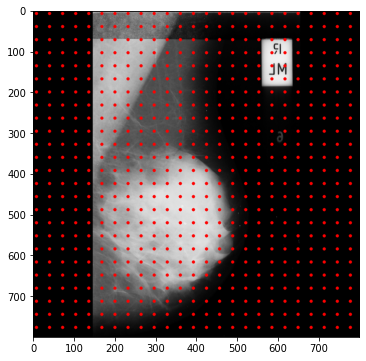

,Unnamed: 0,path,xmin,xmax,ymin,ymax,labels,n_anchor,w_fm,h_fm,x_str,y_str,centre_list
1,1,/content/archive/all-mias/mdb002_resize.jpeg,353.90625,461.71875,527.34375,635.15625,CIRC,625,25,25,32,32,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],..."
2,2,/content/archive/all-mias/mdb005_resize.jpeg,349.21875,396.09375,672.65625,719.53125,CIRC,625,25,25,32,32,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],..."
3,3,/content/archive/all-mias/mdb005_resize.jpeg,370.31250,410.93750,648.43750,689.06250,CIRC,625,25,25,32,32,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],..."


In [56]:
plot_anchors(df1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

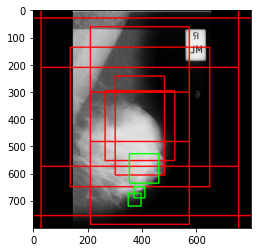

,Unnamed: 0,path,xmin,xmax,ymin,ymax,labels,n_anchor,w_fm,h_fm,x_str,y_str,centre_list,possible_anchors,n_object,anchor_list,bbox_list
1,1,/content/archive/all-mias/mdb002_resize.jpeg,353.90625,461.71875,527.34375,635.15625,CIRC,625,25,25,32,32,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],...",5625,4,"[[-82.50966799187809, -173.01933598375618, 98....","[353.90625, 527.34375, 461.71875, 635.15625]"
2,2,/content/archive/all-mias/mdb005_resize.jpeg,349.21875,396.09375,672.65625,719.53125,CIRC,625,25,25,32,32,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],...",5625,4,"[[-82.50966799187809, -173.01933598375618, 98....","[349.21875, 672.65625, 396.09375, 719.53125]"
3,3,/content/archive/all-mias/mdb005_resize.jpeg,370.31250,410.93750,648.43750,689.06250,CIRC,625,25,25,32,32,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],...",5625,4,"[[-82.50966799187809, -173.01933598375618, 98....","[370.3125, 648.4375, 410.9375, 689.0625]"


In [57]:
anchor_boxes(df1)

### 2.1.3. Intersection over Union (Iou)

In [64]:
def IoU_faster_rcnn (df):
    
    '''

    Calculate Intersection of Union (IoU) between predicted box and ground truth. 

    Params: df containing info on images
    1: image path
    2: x min coord
    3: x max coord
    4: y min coord
    5: y max coord
    6: label
    7: number of anchors
    8: width feature map
    9: height feature map
    10: centre x
    11: centre y
    12: centre list
    13: number of possible anchors 10
    14: number of objects 11
    15: anchor: predicted boxes in arrays. Sorted by xmax, ymax, xmin, ymin 12
    16: boundary box: ground truth in array. Sorted by xmax, ymax, xmin, ymin 13

    Returns: An additional column in passed df with a list of arrays with the obtained IoUs. An extra column with the avg IoU per image
    and it also prints the avg IoU of the model.
    
    '''
    

    # Look for anchor boxes, which are indeed inside the image

    
    anchors = df.iloc[:,15]
    in_anchor_lists = []
    n_in_anchors = []

    for i in anchors:
      in_anchor_idx_list = np.where(
            (i[:,0] >= 0) &
            (i[:,1] >= 0) &
            (i[:,2] <= 800) & 
            (i[:,3] <= 800))[0]
      in_anchor_list = i[in_anchor_idx_list]
      in_anchor_lists.append(in_anchor_list)
      n_in_anchor = len(in_anchor_idx_list)
      n_in_anchors.append(n_in_anchor)

    df['inside_anchor_list'] = in_anchor_lists # column 14 17
    df['n_inside_anchor'] = n_in_anchors # column 15 18

    
    # ------calculate coordinate of overlapping region------

    ious = []
    ious_ = []

    truth = df.iloc[:,16]
    pred = df.iloc[:,17]
    
    for truth, pred in zip(truth, pred):
      i = 0
      for i in range(len(pred)):
        # take max of x1 and y1 out of both boxes
        x1 = max(truth[0], pred[i][0])
        y1 = max(truth[1], pred[i][1])
        # take min of x2 and y2 out of both boxes
        x2 = min(truth[2], pred[i][2])
        y2 = min(truth[3], pred[i][3])
      
        
        # ------area of overlapping region------
        if (x2 < x1 and y2 < y1): # if they don't overlap at all
          width_overlap = 0
          height_overlap = 0
        else:
          width_overlap = (x2 - x1)
          height_overlap = (y2 - y1)

        area_overlap = width_overlap * height_overlap
        area_overlap = [x for x in np.nditer(area_overlap) if x > 0] # keep only positive values
        #area_overlaps.append(area_overlap)      

      
        # ------computing union------
        # sum of area of both the boxes - area_overlap
        
        # height and width of both boxes
        width_truth = (truth[2] - truth[0])
        height_truth = (truth[3] - truth[1])

        width_pred = (pred[i][2] - pred[i][0])
        height_pred = (pred[i][3] - pred[i][1])
        
        # area of box1 and box2
        area_truth = width_truth * height_truth
        area_pred = width_pred * height_pred
        
        # union (including 2 * overlap area (double count))
        area_union_overlap = area_truth + area_pred
        
        # union
        area_union = area_union_overlap - area_overlap
        
        # compute IOU
        iou = area_overlap/ area_union

        if len(iou) < 1:
          iou = 0
        else:
          iou = iou[0]

        ious_.append(iou)

        i += 1
      
      ious.append(ious_)

    df['iou'] = ious
    
    
    # ------ calculate total IoU for the model ------

    avg_ious = []

    for i in df.iloc[:,19]: ## average per image
      avg_iou = sum(i) / len(i)
      avg_ious.append(avg_iou)

    df['avg_iou'] = avg_ious

    avg_iou_model = sum(avg_ious) / len(avg_ious) ## average total model

    print('\n Average IoU value of the Faster R-CNN model is: ', avg_iou_model)


    return df

In [65]:
IoU_faster_rcnn(df1) # apply to our dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

1    [353.90625, 527.34375, 461.71875, 635.15625]
2    [349.21875, 672.65625, 396.09375, 719.53125]
3        [370.3125, 648.4375, 410.9375, 689.0625]
Name: bbox_list, dtype: object
1    [[13.49033200812191, 18.98066401624382, 194.50...
2    [[13.49033200812191, 18.98066401624382, 194.50...
3    [[13.49033200812191, 18.98066401624382, 194.50...
Name: inside_anchor_list, dtype: object

 Average IoU value of the Faster R-CNN model is:  0.012761037364807411


,Unnamed: 0,path,xmin,xmax,ymin,ymax,labels,n_anchor,w_fm,h_fm,...,y_str,centre_list,possible_anchors,n_object,anchor_list,bbox_list,inside_anchor_list,n_inside_anchor,iou,avg_iou
1,1,/content/archive/all-mias/mdb002_resize.jpeg,353.90625,461.71875,527.34375,635.15625,CIRC,625,25,25,...,32,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],...",5625,4,"[[-82.50966799187809, -173.01933598375618, 98....","[353.90625, 527.34375, 461.71875, 635.15625]","[[13.49033200812191, 18.98066401624382, 194.50...",958,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.012761
2,2,/content/archive/all-mias/mdb005_resize.jpeg,349.21875,396.09375,672.65625,719.53125,CIRC,625,25,25,...,32,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],...",5625,4,"[[-82.50966799187809, -173.01933598375618, 98....","[349.21875, 672.65625, 396.09375, 719.53125]","[[13.49033200812191, 18.98066401624382, 194.50...",958,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.012761
3,3,/content/archive/all-mias/mdb005_resize.jpeg,370.31250,410.93750,648.43750,689.06250,CIRC,625,25,25,...,32,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],...",5625,4,"[[-82.50966799187809, -173.01933598375618, 98....","[370.3125, 648.4375, 410.9375, 689.0625]","[[13.49033200812191, 18.98066401624382, 194.50...",958,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.012761


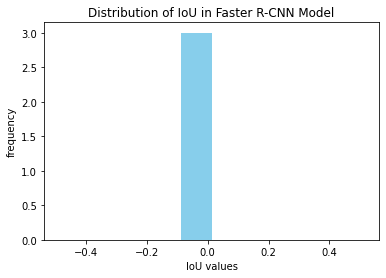

In [67]:
# plot frequency of IoU images

plt.hist(df1['avg_iou'], color = 'skyblue')
plt.title('Distribution of IoU in Faster R-CNN Model')
plt.xlabel('IoU values')
plt.ylabel('frequency')
plt.show()

In [70]:
## check how many images have an IoU of a certain threshold

threshold = 0.02 #### over 0.5 is considered to be good
df1[df1['avg_iou'] > threshold].count()

Unnamed: 0            0
path                  0
xmin                  0
xmax                  0
ymin                  0
ymax                  0
labels                0
n_anchor              0
w_fm                  0
h_fm                  0
x_str                 0
y_str                 0
centre_list           0
possible_anchors      0
n_object              0
anchor_list           0
bbox_list             0
inside_anchor_list    0
n_inside_anchor       0
iou                   0
avg_iou               0
dtype: int64